In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [2]:
! pip install opencv-python
! pip install colab-xterm
%load_ext colabxterm
%xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 11.8 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

In [3]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()


In [6]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import (ImageToArrayPreprocessor,
                                       AspectAwarePreprocessor,
                                       SimplePreprocessor,
                                       MeanPreprocessor)
from loader_util.io import HDF5DatasetGenerator
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet

##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model

In [7]:
# script constants
args = {
    "dataset_path": r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/flowers17/images",
}

In [8]:
# augmentor
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode='nearest',
                         )

In [11]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(args["dataset_path"]))
class_names = [pth.split(os.path.sep)[-2] for pth in image_paths]
class_names = np.unique(class_names)
print(class_names)

[INFO] loading images......
['bluebell' 'buttercup' 'coltsfoot' 'cowslip' 'crocus' 'daffodil' 'daisy'
 'dandelion' 'fritillary' 'iris' 'lilyvalley' 'pansy' 'snowdrop'
 'sunflower' 'tigerlily' 'tulip' 'windflower']


In [12]:
# init the preprocessors
aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

# load the dataset from disk
# simple dataset loader uses opencv - BGR
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [13]:
trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                test_size=0.25,
                                                random_state=42)

lb = LabelBinarizer()
trainy_encoded = lb.fit_transform(trainy)
testy_encoded = lb.transform(testy)

In [14]:
# load vgg16 without the head
base_model = VGG16(include_top=False,
                   weights="imagenet",
                   input_tensor=layers.Input(shape=(224, 224, 3)))

head_model = FCHeadNet.build(base_model=base_model,
                             output_classes=len(class_names),
                             dense_layer_nodes=[256])

model = Model(inputs=base_model.input,
              outputs=head_model)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
print(f"[INFO] compiling the model......")
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

[INFO] compiling the model......


In [17]:
print(f"[INFO] training the head......")
H1 = model.fit(aug.flow(trainx, trainy_encoded, batch_size=32),
          validation_data=(testx, testy_encoded),
          epochs=25,
          steps_per_epoch=len(trainx)//32,
          verbose=1)

[INFO] training the head......


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1342 - loss: 7.9347 - val_accuracy: 0.2853 - val_loss: 2.2068
Epoch 2/25
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.2188 - loss: 2.4828

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2188 - loss: 2.4828 - val_accuracy: 0.4176 - val_loss: 2.1357
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.2345 - loss: 2.4353 - val_accuracy: 0.3794 - val_loss: 1.8671
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2812 - loss: 2.4497 - val_accuracy: 0.4471 - val_loss: 1.8184
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3296 - loss: 2.0693 - val_accuracy: 0.6088 - val_loss: 1.4490
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3125 - loss: 1.9597 - val_accuracy: 0.6265 - val_loss: 1.3727
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.3682 - loss: 1.9419 - val_accuracy: 0.6353 - val_loss: 1.2367
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4375 - loss: 1.6731 - val_accuracy: 0.6912 - val_loss: 1.1173
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.4674 - loss: 1.6438 - val_accuracy: 0.7235 - val_

[INFO] evaluating network...
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
              precision    recall  f1-score   support

    bluebell       0.70      0.80      0.74        20
   buttercup       0.83      0.95      0.88        20
   coltsfoot       0.71      0.94      0.81        16
     cowslip       0.86      0.63      0.73        19
      crocus       1.00      0.60      0.75        15
    daffodil       0.82      0.90      0.86        20
       daisy       0.91      0.91      0.91        23
   dandelion       1.00      0.74      0.85        27
  fritillary       0.79      1.00      0.88        19
        iris       0.95      0.90      0.93        21
  lilyvalley       0.80      0.89      0.84        18
       pansy       0.94      0.94      0.94        16
    snowdrop       0.80      0.73      0.76        22
   sunflower       1.00      0.96      0.98        23
   tigerlily       0.77      0.94      0.85        18
       tulip       1.00      0.55      0.71        20
  windflowe

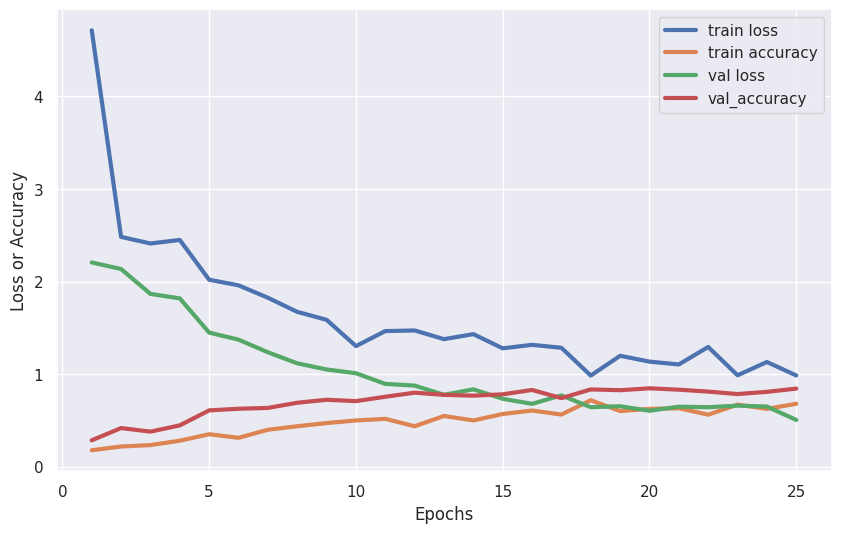

In [20]:
# evaluate the network
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

# plot the performance
epochs = range(1, 26)
loss = H1.history['loss']
accuracy = H1.history['accuracy']
val_loss = H1.history['val_loss']
val_accuracy = H1.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs');

In [21]:
# after warming up FC layers, lets unfreeze final set of conv layers
for layer in base_model.layers[15:]:
    layer.trainable = True

In [22]:
print(f"[INFO] recompiling the model......")
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
print(f"[INFO] fine tuning the model......")
H2 = model.fit(aug.flow(trainx, trainy_encoded, batch_size=32),
               validation_data=(testx, testy_encoded),
               epochs=100,
               steps_per_epoch=len(trainx)//32,
               verbose=1)

[INFO] recompiling the model......
[INFO] fine tuning the model......


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.6950 - loss: 0.8943 - val_accuracy: 0.8941 - val_loss: 0.4087
Epoch 2/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7188 - loss: 0.6709

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7188 - loss: 0.6709 - val_accuracy: 0.8794 - val_loss: 0.4222
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.7442 - loss: 0.7344 - val_accuracy: 0.8971 - val_loss: 0.3650
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9062 - loss: 0.3840 - val_accuracy: 0.8941 - val_loss: 0.3661
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7488 - loss: 0.6752 - val_accuracy: 0.9059 - val_loss: 0.3547
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8438 - loss: 0.5685 - val_accuracy: 0.9088 - val_loss: 0.3425
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.7403 - loss: 0.6909 - val_accuracy: 0.9029 - val_loss: 0.3385
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9062 - loss: 0.5138 - val_accuracy: 0.9088 - val_loss: 0.3375
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.7796 - loss: 0.6953 - val_accuracy: 0.9029

[INFO] evaluating network...
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step
              precision    recall  f1-score   support

    bluebell       0.95      0.95      0.95        20
   buttercup       0.91      1.00      0.95        20
   coltsfoot       0.88      0.88      0.88        16
     cowslip       0.88      0.74      0.80        19
      crocus       0.81      0.87      0.84        15
    daffodil       0.86      0.90      0.88        20
       daisy       1.00      0.83      0.90        23
   dandelion       0.96      0.93      0.94        27
  fritillary       0.95      1.00      0.97        19
        iris       1.00      0.95      0.98        21
  lilyvalley       0.94      0.94      0.94        18
       pansy       0.94      1.00      0.97        16
    snowdrop       0.87      0.91      0.89        22
   sunflower       0.96      1.00      0.98        23
   tigerlily       0.86      1.00      0.92        18
       tulip       1.00      0.80      0.89        20
  windflowe

Text(0.5, 0, 'Epochs')

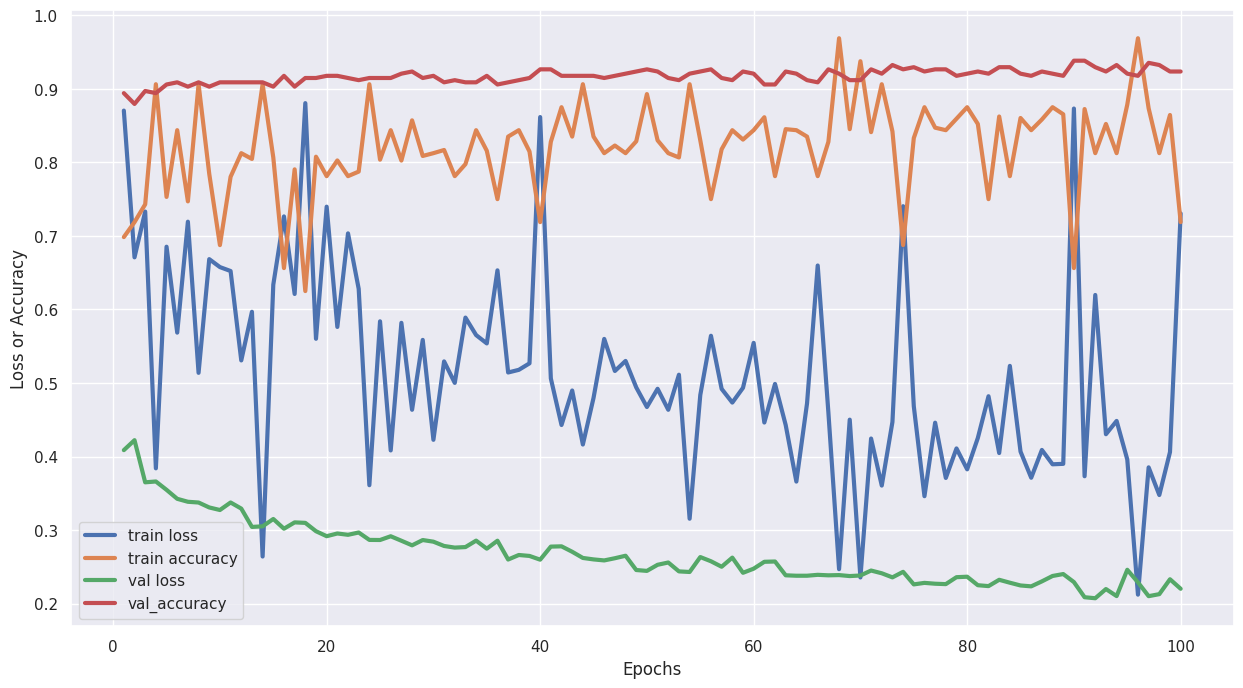

In [23]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

# plot the performance
epochs = range(1, 101)
loss = H2.history['loss']
accuracy = H2.history['accuracy']
val_loss = H2.history['val_loss']
val_accuracy = H2.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')